**Imports and drive mount**
---

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense 
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
import numpy as np
from PIL import Image
from tqdm import tqdm
import os 
import time
import matplotlib.pyplot as plt

try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    COLAB = True
    print("Note: using Google CoLab")
    %tensorflow_version 2.x
except:
    print("Note: not using Google CoLab")
    COLAB = False

Mounted at /content/drive
Note: using Google CoLab


**Data Pulling**
---
Whoever coded this: Tell me something about it. That's the whole point of Colab. Also, what's with all the trash comments and clutter? 

In [ ]:
tileUp_nonVisualFeatures = True

# Generation resolution - Must be square 
# Training data is also scaled to this.
# Note GENERATE_RES 4 or higher  
# will blow Google CoLab's memory and have not
# been tested extensivly.
GENERATE_RES = 8 # Generation resolution factor  # 8 == 256
# (1=32, 2=64, 3=96, 4=128, etc.)
GENERATE_SQUARE = 32 * GENERATE_RES # rows/cols (should be square)
IMAGE_CHANNELS = 3      

# Preview image 
PREVIEW_ROWS = 4
PREVIEW_COLS = 7
PREVIEW_MARGIN = 16

# Size vector to generate images from
SEED_SIZE = 100

# Configuration
DATA_PATH = "/content/drive/My Drive/gan-getting-started/monet_jpg"

load_extra_monets = True
EPOCHS = 5
BATCH_SIZE = 32
BUFFER_SIZE = 60000

TRAIN_GENERATOR_ON_ONES = True
TRAIN_GENERATOR_ON_KAGGLE_PHOTOS = False
KAGGLE_PHOTOS_PATH = "/content/drive/My Drive/gan-getting-started/photo_jpg"

training_binary_path = os.path.join(DATA_PATH,  f'training_data_{GENERATE_SQUARE}_{GENERATE_SQUARE}.npy')

# print(f"Will generate {GENERATE_SQUARE}px square images.")

# Image set has 11,682 images.  Can take over an hour
# for initial preprocessing.
# Because of this time needed, save a Numpy preprocessed file.
# Note, that file is large enough to cause problems for 
# sume verisons of Pickle,
# so Numpy binary files are used.
# training_binary_path = os.path.join(DATA_PATH,  f'training_data_{GENERATE_SQUARE}_{GENERATE_SQUARE}.npy') 
# import os
# os.chdir("/content/drive/My Drive/gan-getting-started/monet_jpg")
# !ls

def pull_data(DATA_PATH, max_samples_to_load=None):
  data = []
  monets_path = os.path.join(DATA_PATH)

  if max_samples_to_load==None:
    for filename in tqdm(os.listdir(monets_path)):     

        if os.path.isfile(os.path.join(monets_path,filename)):
            path = os.path.join(monets_path,filename)

            if path.endswith('.jpg'):
              image = Image.open(path) .resize((GENERATE_SQUARE, GENERATE_SQUARE), Image.ANTIALIAS)    
              data.append( np.asarray( image ))
  else:
    i = 0
    for filename in tqdm(os.listdir(monets_path)):     
        if i >= max_samples_to_load:
          break

        if os.path.isfile(os.path.join(monets_path,filename)):
            path = os.path.join(monets_path,filename)

            if path.endswith('.jpg'):
              image = Image.open(path) .resize((GENERATE_SQUARE, GENERATE_SQUARE), Image.ANTIALIAS)    
              data.append( np.asarray( image ))
        i=i+1

  # [TODO]: printe mal 20 bilder.

  return data
if not os.path.isfile(training_binary_path):
  training_data = pull_data(DATA_PATH)
  np.save(training_binary_path, training_data)
else:
  training_data = np.load(training_binary_path)
print("Data-shape direkt nach pull:", np.shape(training_data))
training_data = np.reshape( training_data, (-1, GENERATE_SQUARE,   GENERATE_SQUARE, IMAGE_CHANNELS))
training_data = training_data.astype( np.float32 )
fid_image1 = training_data
fid_image1.shape

Data-shape direkt nach pull: (300, 256, 256, 3)


(300, 256, 256, 3)

In [ ]:

# RESAMPLING.
'''
def grayscale_rgb_np_arrs(training_data): 
  return np.tensordot(training_data[:,:,:3], [0.299, 0.587, 0.114], axes=1)
gray = grayscale_rgb_np_arrs(training_data)
gray_0 = Image.fromarray(gray[0].astype('uint8'), 'P')

from matplotlib.pyplot import imshow
imshow(gray_0)
LOL
'''
import cv2
def grayscale_rgb_np_arrs(training_data):
  train_grayscale = np.zeros(training_data.shape[:-1])
  for i in range(training_data.shape[0]): 
    train_grayscale[i] = cv2.cvtColor(training_data[i], cv2.COLOR_RGB2GRAY)
  return train_grayscale
grays =grayscale_rgb_np_arrs(training_data) 

#plt.imshow(training_data[0,:,:,0])
#plt.imshow(training_data[0,:,:,1])
#plt.imshow(grays[0])
#o=o
# 1. schwarz weiß version, inevertierte Version, gespiegelt (== alle für das gleiche sample weil 3 Channels sowieso existieren.) => 600 samples.
# 2. vertikal spiegeln, + 
# 3. Viertel ausschnitte
# 4. Extra Samples
# 5. 

# FEATURE EXTRACTION. 
# PRINTE die Verteilungen direkt mit z.b. v. den Average RGBs über jedes Bild. 

def get_mean_RGBs_of_img(training_data):
  new_shape = (training_data.shape[0], training_data.shape[1]*training_data.shape[2], training_data.shape[3] )
  return training_data.reshape(new_shape).mean(axis=1)
nonVis_train_data = get_mean_RGBs_of_img(training_data)

#
training_data = training_data / 127.5 - 1.


#print("Saving training image binary...")
#np.save(training_binary_path,training_data) 
 



# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices( training_data )   .shuffle(BUFFER_SIZE). batch(BATCH_SIZE)



# tensorize data.
training_data = tf.convert_to_tensor(training_data)

print("Data-shape direkt nach preprocessing:", training_data.shape)

Data-shape direkt nach preprocessing: (300, 256, 256, 3)


In [ ]:
def build_generator(seed_size, channels):

    model = Sequential()

    model.add(Dense(4*4*256,activation="relu",input_dim=seed_size))
    model.add(Reshape((4,4,256)))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))           
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))            
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
   
    # Output resolution, additional upsampling
    model.add(UpSampling2D())
    model.add(Conv2D(128,kernel_size=3,padding="same"))          
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    

    if GENERATE_RES>1:
      model.add(UpSampling2D(size=(GENERATE_RES,GENERATE_RES)))
      model.add(Conv2D(128,kernel_size=3,padding="same"))
      model.add(BatchNormalization(momentum=0.8))
      model.add(Activation("relu"))

    # Final CNN layer
    model.add(Conv2D(channels,kernel_size=3,padding="same"))
    model.add(Activation("tanh"))


    tf.keras.utils.plot_model(model)

    return model


def build_discriminator(image_shape):
    model = Sequential()

    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=image_shape, 
                     padding="same", ))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
     
    tf.keras.utils.plot_model(model)

    return model

In [ ]:
def save_images(cnt,noise):
  image_array = np.full(( 
      PREVIEW_MARGIN + (PREVIEW_ROWS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 
      PREVIEW_MARGIN + (PREVIEW_COLS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 3), 
      255, dtype=np.uint8)
  
  generated_images = generator.predict(noise)

  generated_images = 0.5 * generated_images + 0.5

  image_count = 0
  for row in range(PREVIEW_ROWS):
      for col in range(PREVIEW_COLS):
        r = row * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        c = col * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        image_array[r:r+GENERATE_SQUARE,c:c+GENERATE_SQUARE] \
            = generated_images[image_count] * 255
        image_count += 1

          
  output_path = os.path.join(DATA_PATH,'output')
  if not os.path.exists(output_path):
    os.makedirs(output_path)
  
  filename = os.path.join(output_path,f"train-{cnt}.png")
  im = Image.fromarray(image_array)
  im.save(filename)

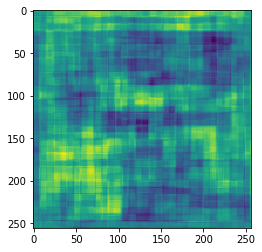

In [ ]:
generator = build_generator(SEED_SIZE, IMAGE_CHANNELS)

noise = tf.random.normal([1, SEED_SIZE])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

In [ ]:
image_shape = (GENERATE_SQUARE,GENERATE_SQUARE,IMAGE_CHANNELS)

discriminator = build_discriminator(image_shape)
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.49996334]], shape=(1, 1), dtype=float32)


In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)



generator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)


In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
# Nicely formatted time string
def hms_string( sec_elapsed ):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

@tf.function
def train_step_on_random(images):
  seed = tf.random.normal([BATCH_SIZE, SEED_SIZE])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(seed, training=True)

    real_output = discriminator(images, training=True) #monet
    fake_output = discriminator(generated_images, training=True) # random created pic

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
    

    gradients_of_generator = gen_tape.gradient(  gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(  disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(  gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip( gradients_of_discriminator, discriminator.trainable_variables))

  return gen_loss,disc_loss

#----------------------------------------------------------+

@tf.function
def train_step_on_ones(images):
  seed = tf.ones([BATCH_SIZE, SEED_SIZE])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(seed, training=True)

    real_output = discriminator(images, training=True) #monet
    fake_output = discriminator(generated_images, training=True) # random created pic

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
    

    gradients_of_generator = gen_tape.gradient(  gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(  disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(  gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip( gradients_of_discriminator, discriminator.trainable_variables))

  return gen_loss,disc_loss

#----------------------------------------------------------+

@tf.function
def train_step_on_photos(images, input_photo): 

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(input_photo, training=True)

    real_output = discriminator(images, training=True) #monet
    fake_output = discriminator(generated_images, training=True) # random created pic

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
     
    gradients_of_generator = gen_tape.gradient(  gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(  disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(  gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip( gradients_of_discriminator, discriminator.trainable_variables))

  return gen_loss,disc_loss





def train(dataset, epochs,  TRAIN_GENERATOR_ON_KAGGLE_PHOTOS, kaggle_photos):

  if  TRAIN_GENERATOR_ON_KAGGLE_PHOTOS==False:
    fixed_seed = np.random.normal(0, 1, (PREVIEW_ROWS * PREVIEW_COLS, SEED_SIZE))
    start = time.time()

    for epoch in range(epochs): 
      epoch_start = time.time()

      gen_loss_list = []
      disc_loss_list = []

      for image_batch in dataset:
        t = train_step_on_random(image_batch)
        gen_loss_list.append(t[0])
        disc_loss_list.append(t[1])

      g_loss = sum(gen_loss_list) / len(gen_loss_list)
      d_loss = sum(disc_loss_list) / len(disc_loss_list)

      epoch_elapsed = time.time()-epoch_start
      print (f'Epoch {epoch+1}, gen loss={g_loss},disc loss={d_loss},'\
            ' {hms_string(epoch_elapsed)}')
      save_images(epoch,fixed_seed)


      # [TODO]: make it work:
      #if epoch%10==0:
      #  noise = tf.random.normal([1, SEED_SIZE])
      #  generated_image = generator(noise, training=False) 
      #  plt.imshow(generated_image[0, :, :, 0])
  elif TRAIN_GENERATOR_ON_ONES:
    fixed_seed = np.random.normal(0, 1, (PREVIEW_ROWS * PREVIEW_COLS, SEED_SIZE))
    start = time.time()

    for epoch in range(epochs): 
      epoch_start = time.time()

      gen_loss_list = []
      disc_loss_list = []

      for image_batch in dataset:
        t = train_step_one_ones(image_batch)
        gen_loss_list.append(t[0])
        disc_loss_list.append(t[1])

      g_loss = sum(gen_loss_list) / len(gen_loss_list)
      d_loss = sum(disc_loss_list) / len(disc_loss_list)

      epoch_elapsed = time.time()-epoch_start
      print (f'Epoch {epoch+1}, gen loss={g_loss},disc loss={d_loss},'\
            ' {hms_string(epoch_elapsed)}')
      save_images(epoch,fixed_seed)

  else:

      fixed_seed = np.random.normal(0, 1, (PREVIEW_ROWS * PREVIEW_COLS, 
                                        SEED_SIZE))
      start = time.time()

      for epoch in range(epochs): 
        epoch_start = time.time()

        gen_loss_list = []
        disc_loss_list = []

        for image_batch in dataset :
          print(image_batch)
          print("image batch shape", image_batch.shape)
          t = train_step(image_batch)
          gen_loss_list.append(t[0])
          disc_loss_list.append(t[1])

        g_loss = sum(gen_loss_list) / len(gen_loss_list)
        d_loss = sum(disc_loss_list) / len(disc_loss_list)

        epoch_elapsed = time.time()-epoch_start
        print (f'Epoch {epoch+1}, gen loss={g_loss},disc loss={d_loss},'\
              ' {hms_string(epoch_elapsed)}')
        save_images(epoch, fixed_seed)
    
if TRAIN_GENERATOR_ON_KAGGLE_PHOTOS:
  photos = pull_data( KAGGLE_PHOTOS_PATH, max_samples_to_load=300)
  # ACHTUNG: wir haben aktuell +7000 bilder auf 300 samples -> down oder upsampling des ein oder anderen (aktuell werden nur die ersten 300 PHOTOS genutzt weil iterator von "dataset" ausgeht)
  photos = np.reshape( photos, (-1, GENERATE_SQUARE,   GENERATE_SQUARE, IMAGE_CHANNELS))
  photos = photos.astype( np.float32 )
 
  photos = photos / 127.5 - 1. 

  print(photos.shape)
  # Batch and shuffle the data
  photos = tf.data.Dataset.from_tensor_slices( photos )   .shuffle(BUFFER_SIZE). batch(BATCH_SIZE)
 
  # tensorize data.
  photos = tf.convert_to_tensor(photos)

  print(photos.shape)
  print(training_data.shape)
else: 
  photos = None


#o=o
train(train_dataset, EPOCHS, TRAIN_GENERATOR_ON_KAGGLE_PHOTOS, photos)
print("trained")

import time
id = time.time()
generator.save(os.path.join(DATA_PATH,f"Monet_generator_{id}.h5"))
discriminator.save(os.path.join(DATA_PATH,f"Monet_discriminator_{id}.h5"))

KeyboardInterrupt: ignored

In [ ]:
noise = tf.random.normal([1, SEED_SIZE])
generated_image = generator(noise, training=False)
 
plt.imshow(generated_image[0, :, :, 0])

## **FID Evaluation**

Code from https://machinelearningmastery.com/how-to-implement-the-frechet-inception-distance-fid-from-scratch/

In [ ]:
#imports (to be moved to the top)

import numpy
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import shuffle
from scipy.linalg import sqrtm
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from skimage.transform import resize

In [ ]:
print(type(training_data))
print(training_data.shape)

test_img = cifar10.load_data()
print(np.shape(test_img))
print(type(test_img))

merged_data = training_data, training_data

# print(merged_data)

<class 'numpy.ndarray'>
(300, 256, 256, 3)
(2, 2)
<class 'tuple'>


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [ ]:
# scale an array of images to a new size
def scale_images(images, new_shape):
	images_list = list()
	for image in images:
		# resize with nearest neighbor interpolation
		new_image = resize(image, new_shape, 0)
		# store
		images_list.append(new_image)
	return np.asarray(images_list)
 
# calculate frechet inception distance
def calculate_fid(model, images1, images2):
	# calculate activations
	act1 = model.predict(images1)
	act2 = model.predict(images2)
	# calculate mean and covariance statistics
	mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
	mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
	# calculate sum squared difference between means
	ssdiff = np.sum((mu1 - mu2)**2.0)
	# calculate sqrt of product between cov
	covmean = sqrtm(sigma1.dot(sigma2))
	# check and correct imaginary numbers from sqrt
	if iscomplexobj(covmean):
		covmean = covmean.real
	# calculate score
	fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
	return fid
 
# prepare the inception v3 model
model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))
# load images
images1 = training_data
images2 = training_data
print('Loaded', images1.shape, images2.shape)
# convert integer to floating point values
images1 = images1.astype('float32')
images2 = images2.astype('float32')
# resize images
images1 = scale_images(images1, (299,299,3))
images2 = scale_images(images2, (299,299,3))
print('Scaled', images1.shape, images2.shape)
# pre-process images
images1 = preprocess_input(images1)
images2 = preprocess_input(images2)
# calculate fid
fid = calculate_fid(model, images1, images2)
print('FID: %.3f' % fid)

Loaded (300, 256, 256, 3) (300, 256, 256, 3)
Scaled (300, 299, 299, 3) (300, 299, 299, 3)
FID: -0.000
